In [141]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import joblib
import time
import recognizer

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
#from tqdm.notebook import tqdm
from tqdm import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

from keras.models import load_model

NUM_POINTS = 50

encoder = joblib.load('label_encoder.pkl')
label_classes = encoder.classes_

In [78]:
data = []

for root, subdirs, files in os.walk('dataset/my-dataset'): #changed path
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]

                if label in label_classes: #delete wrong labeled data, for example zig zag not in the dataset
                
                    xml_root = ET.parse(f'{root}/{f}').getroot()
                    
                    points = []
                    for element in xml_root.findall('Point'):
                        x = element.get('X')
                        y = element.get('Y')
                        points.append([x, y])
                        
                    points = np.array(points, dtype=float)
                    
                    scaler = StandardScaler()
                    points = scaler.fit_transform(points)
                    
                    resampled = resample(points, NUM_POINTS)
                    
                    data.append((label, resampled))

100%|██████████| 160/160 [00:00<00:00, 1926.21it/s]


In [79]:
print(data[0])

('delete_mark', array([[-1.27340389, -1.07641757],
       [-1.45616032, -1.03892201],
       [-1.08848905, -1.10592199],
       [-1.38913426, -1.06753464],
       [-1.21448721, -1.07410462],
       [-0.79418616, -0.88213274],
       [-0.43842786, -0.53314036],
       [ 0.11704125, -0.18854086],
       [ 0.46360298,  0.13471142],
       [ 0.6831529 ,  0.31048933],
       [ 0.90980458,  0.44822495],
       [ 0.99309703,  0.58204624],
       [ 1.08953968,  0.62516033],
       [ 1.21001072,  0.73483528],
       [ 1.32189339,  0.86264167],
       [ 1.39214068,  0.88814264],
       [ 1.38170563,  0.90618397],
       [ 1.38552372,  0.91877108],
       [ 1.33073976,  0.91620803],
       [ 1.20052645,  0.92100855],
       [ 1.00377484,  0.91726162],
       [ 0.63773652,  0.9183199 ],
       [ 0.22539452,  0.91808425],
       [-0.12458108,  0.924707  ],
       [-0.44457608,  0.94042678],
       [-0.73127531,  0.95377007],
       [-0.98870026,  0.99128408],
       [-1.2121315 ,  1.03700694],
    

## Let's have a look at our data

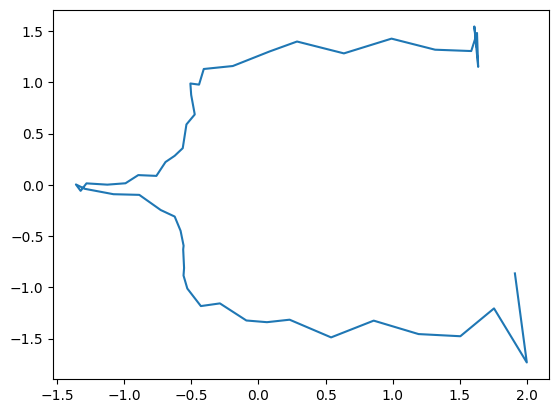

In [109]:
test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

In [120]:
labels = [sample[0] for sample in data]
labels_encoded = encoder.transform(labels) # used transform instead of fit_transform because encoder should not be changed
y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
X = np.array(sequences)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
# use whole Dataset for training
X_test = X
y_test = y

print(X_test.shape, y_test.shape)
print(labels_encoded)

16
(150, 50, 2) (150, 16)
[ 4  1  5  5  6  4 14 14 10  4  4 12 13  0  1  6  9  5  9  6  1  0 13 12
  4 10 14 15 14  4 11  1  6  5  5  5  6  1 11 14 15 14  4  3  6  1  1  5
  5  1  6  6  3  4 14 14  7  7  2  2  2  7  2  2  2  7  7  2  2  7  7  2
  7  7  7  2 15 14 10 12 11 13  0  3  9  3  1  6  6  1  3  9  0 13 11 12
 10 14 15 15 10 11 11  0 13  9  3  5  5  3 11 12 15 15 10 10  4 12 13  0
  0 13 11  9  3  9  3  9 13  0 12 12  4 10 15 15 10 12 13  0 11  9  3  9
 11  0 13 12 10 15]


In [121]:
for label, encoded in zip(encoder.classes_, range(len(encoder.classes_))):
    print(f"{label}: {encoded}")

arrow: 0
caret: 1
check: 2
circle: 3
delete_mark: 4
left_curly_brace: 5
left_sq_bracket: 6
pigtail: 7
question_mark: 8
rectangle: 9
right_curly_brace: 10
right_sq_bracket: 11
star: 12
triangle: 13
v: 14
x: 15


In [171]:
model_64 = load_model("models/gesture_64_neurons.keras")
model_32 = load_model("models/gesture_32_neurons.keras")
model_16 = load_model("models/gesture_16_neurons.keras")

In [172]:
start_time = time.time()
y_predictions = model_16.predict(X_test)
prediction_time_16 = time.time() - start_time

y_predictions = np.argmax(y_predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy_16 = accuracy_score(y_test_labels, y_predictions)

print(f"Accuracy: {accuracy_16 * 100:.2f}%")
print(f"Prediction Time: {prediction_time_16:.4f} seconds")

#prediction_label = encoder.inverse_transform(np.array([y_predictions]))[0]

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Accuracy: 62.67%
Prediction Time: 0.7609 seconds


In [173]:
start_time = time.time()
y_predictions = model_32.predict(X_test)
prediction_time_32 = time.time() - start_time

y_predictions = np.argmax(y_predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy_32 = accuracy_score(y_test_labels, y_predictions)

print(f"Accuracy: {accuracy_32 * 100:.2f}%")
print(f"Prediction Time: {prediction_time_32:.4f} seconds")

#prediction_label = encoder.inverse_transform(np.array([y_predictions]))[0]

1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/stepWARNING:tensorflow:5 out of the last 85 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x31f122840> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Accuracy: 75.33%
Prediction Time: 0.6174 seconds


In [174]:
start_time = time.time()
y_predictions = model_64.predict(X_test)
prediction_time_64 = time.time() - start_time

y_predictions = np.argmax(y_predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy_64 = accuracy_score(y_test_labels, y_predictions)

print(f"Accuracy: {accuracy_64 * 100:.2f}%")
print(f"Prediction Time: {prediction_time_64:.4f} seconds")

#prediction_label = encoder.inverse_transform(np.array([y_predictions]))[0]

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Accuracy: 82.00%
Prediction Time: 0.6025 seconds


In [149]:
dollarRecognizer = recognizer.DollarRecognizer()

test_data = recognizer.load_unistrokes_from_XML("dataset/my-dataset")

true = 0
false = 0

start_time = time.time()
for unistroke in test_data:
    if unistroke.name == dollarRecognizer.recognize(unistroke.points).name:
        true = true + 1
    else:
        false = false + 1
prediction_time_dollar_recognizer = time.time() - start_time
print("True: ", str(true), "False: ", str(false))
accuracy_dollar_recognizer = true/(true+false)
print(f"Accuracy: {accuracy_dollar_recognizer * 100:.2f}%")
print(f"Prediction Time: {prediction_time_dollar_recognizer:.4f} seconds")

<built-in method keys of dict object at 0x31d13af00>
True:  74 False:  86
Accuracy: 46.25%
Prediction Time: 5.9182 seconds


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


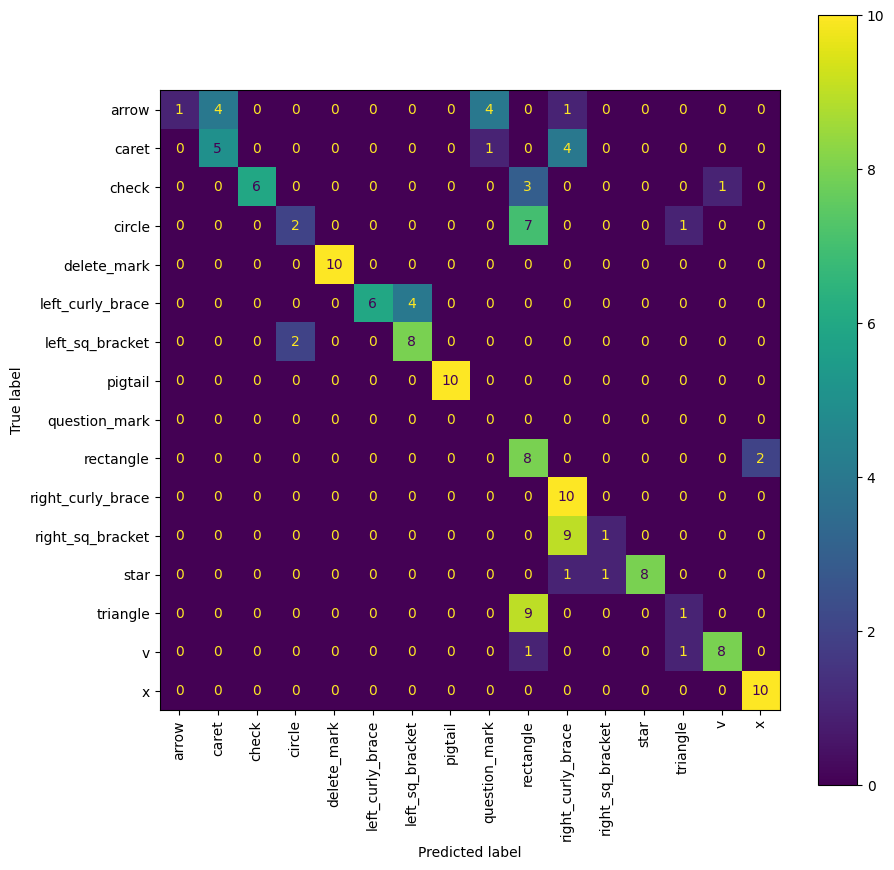

In [175]:
# let the model make predictions for our training data
y_predictions = model_16.predict(X_test)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_classes).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Label:      right_curly_brace
Prediction: right_curly_brace


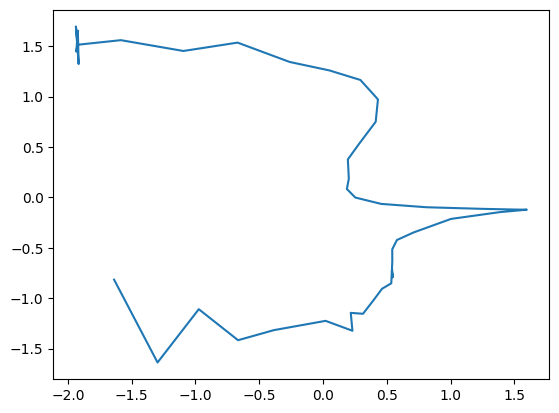

In [176]:
# lets test the model in action

test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

prediction = model_64.predict(np.array([sequence]))
prediction = np.argmax(prediction)

prediction_label = encoder.inverse_transform(np.array([prediction]))[0]

print('Label:     ', label)
print('Prediction:', prediction_label)

# Auswertung

## Accuracy

Die Accurary nimmt mit zunehmender Neuronenzahl bei den LSTM-Modellen zu. Der Dollar Recognizer erkennt dafür weniger als die Hälfte meiner Daten zuverlässig.

Die hohe Accuracy spricht dafür, ein LSTM-Modell mit vielen Neuronen zu verwenden.

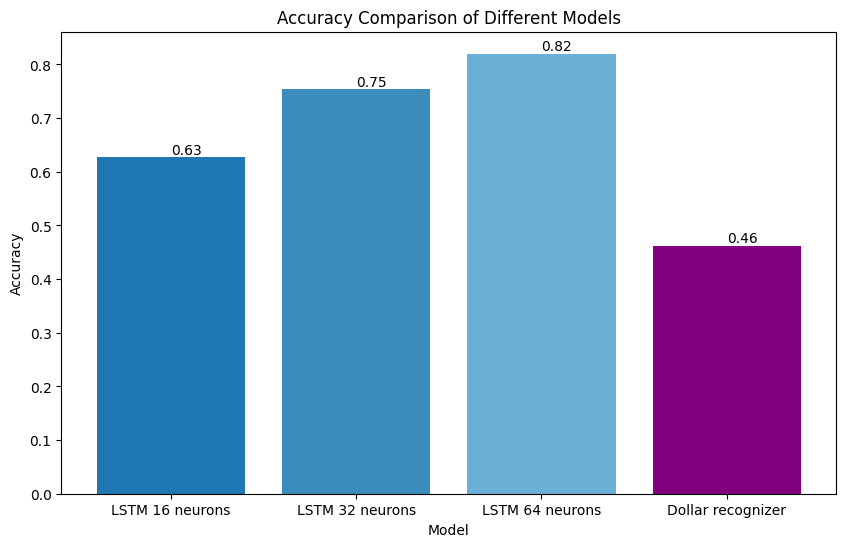

In [177]:
labels = ['LSTM 16 neurons', 'LSTM 32 neurons', 'LSTM 64 neurons', 'Dollar recognizer']

accuracies = [accuracy_16, accuracy_32, accuracy_64, accuracy_dollar_recognizer]

plt.figure(figsize=(10, 6)) 
bars = plt.bar(labels, accuracies, color=['#1f77b4', '#3c8dbc', '#6baed6', 'purple'])

plt.title('Accuracy Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom')  # Wert auf dem Balken anzeigen

plt.show()

## Prediction Time

Die Zeit für Vorhersagen nimmt mit zunehmender Neuronenzahl bei den LSTM-Modellen ab. Die Zeiten der LSTM Modelle sind aber alle sehr gering im vergleich zum Dollar Recognizer, der für die Vorhersagen über das 7-fache der Zeit benötigt.

Die die kurzen Vorhersagezeiten sprichen dafür, ein LSTM-Modell mit vielen Neuronen zu verwenden, um bei Anwendungen dem Nutzer in Echtzeit Feedback geben zu können und dadurch die Usability zu erhöhen.

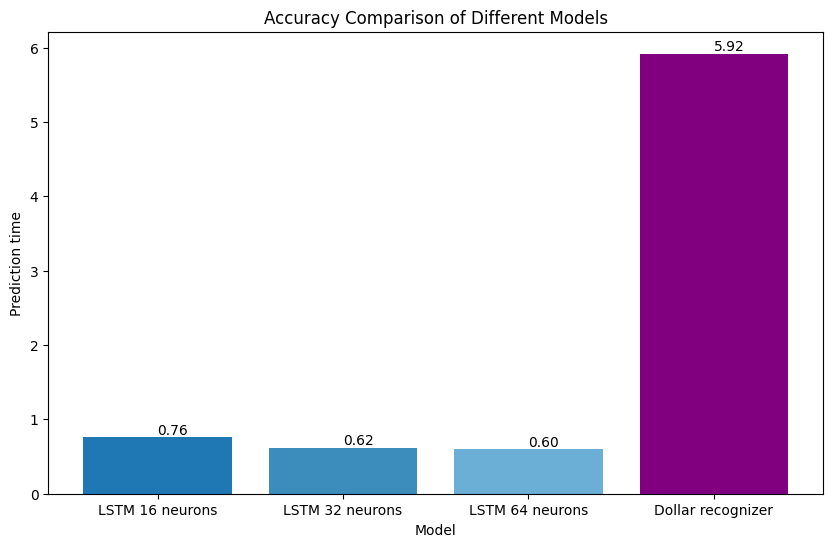

In [178]:
labels = ['LSTM 16 neurons', 'LSTM 32 neurons', 'LSTM 64 neurons', 'Dollar recognizer']

accuracies = [prediction_time_16, prediction_time_32, prediction_time_64, prediction_time_dollar_recognizer]

plt.figure(figsize=(10, 6)) 
bars = plt.bar(labels, accuracies, color=['#1f77b4', '#3c8dbc', '#6baed6', 'purple'])

plt.title('Accuracy Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('Prediction time')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom')  # Wert auf dem Balken anzeigen

plt.show()